# 图像风格迁移|AI艺术家

**Author: 布尔艺数**
<div algin=center>
<img src="https://github.com/EvilPsyCHo/BoolArt/blob/main/logo/logo_horizontal.png?raw=true" width = "300" height = "200" />
</div>


|原图|风格图片|迁移动画|
|:|:|:|
|<img src="asset/1_image_style_transfer/hinton.png" width = "300" height = "200" />|<img src="asset/1_image_style_transfer/picasso2.jpg" width = "300" height = "200" />|<img src="asset/1_image_style_transfer/hinton_picasso2.gif" width = "300" height = "200" />|


图像风格迁移是在保持原图片内容情况下，将一些艺术图片风格元素融入，看起来像是由艺术家重新画了一版。

最近公司要印制一版致敬深度学习先驱Hinton的文化杉，由于暂时请不起画家专门帮我们创作：D，所以我们决定让AI艺术家来帮忙【笑】。上面一组图是基于论文[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)方法，将毕加索自画像风格嵌入到Hinton个人照片上的效果【莫名苏联风 XD】。


OK。那我们在讲解原理和实践前，先导入我们需要的工作环境，主要是深度学习框架PyTorch及，基于PyTorch的计算机视觉模型预训练库timm，图像数据处理&增强库albumentations.

In [2]:
import os
import sys

import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import imageio

%matplotlib inline
datadir = "./asset/1_image_style_transfer/"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"python       : {sys.version}")
print(f"torch        : {torch.__version__}")
print(f"timm         : {timm.__version__}")
print(f"device       : {torch.cuda.get_device_name()}")

python       : 3.8.0 (default, Nov  6 2019, 21:49:08) 
[GCC 7.3.0]
torch        : 1.9.1+cu111
timm         : 0.5.4
device       : NVIDIA GeForce RTX 3090


## 工作原理

coding之前，我们还是希望能弄懂这个东西是怎么工作的，如何将绘画风格从一个图片迁移到另一个图片呢。



### 1. 利用预训练卷积神经网络提取内容图片与风格图片的各层级表示；

经过良好预训练的卷积神经网络能有效提取图像的表征，不同层级的卷积表征有不同的作用，高层表征越抽象，低层表征粒度细且直观：
<img src="asset/1_image_style_transfer/cnn_visualization.gif" width = "300" height = "200"/>

从下图也可以很直观的看到，在不同层级表征下，对图像风格和图像内容的重建效果有明显差异；
- 内容重建在低层表征下细节处理的非常好，几乎能复现原图片，在高层表征下有一定的细节损失；
- 风格重建在低层表征下由于抽象层次过低，很难完美复现风格，但是在高层表征下运行很好；

为了能完美兼顾细节和整体，我们的损失函数构建将使用多种层次的表征一起优化；

<img src="asset/1_image_style_transfer/model.png" width="400" height="300" />

这里我们采用VGG预训练网络，并选取其中第0,5,10,19,28层对应的卷积输出作为不同抽象层次的表征：

In [15]:
class VGGStyleModel(nn.Module):
    def __init__(self):
        super(VGGStyleModel, self).__init__()
        self.req_features= ['0','5','10','19','28']
        #self.req_features= ['10','19','28']
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=timm.models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features

### 2. 构造内容表示损失函数

<img src="asset/1_image_style_transfer/content_loss.png" width="300" height="200"/>


其中$p$, $P^l_{i,j}$表示内容图片以及原图片在第$l$层卷积下第$i$个通道的位置$j$的表示，$x$, $F^l_{i,j}$表示生成图片以及生成图片在第$l$层卷积下第$i$个通道的位置$j$的表示；

以上是公式的含义，但我更愿意用更加直觉的表述这个损失函数：度量生成图片和内容图片，在各个抽象层次的像素层面上的差异，通过降低差异（优化损失函数），使得生成图像尽可能保留内容图像上的信息；

In [10]:
def calc_content_loss(gen_feat,orig_feat):
    # 计算生成图片特征图与原始图片特征图内容差异损失
    # calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)
    return content_l

### 3. 构造风格表示损失函数

什么是风格，存在自己特性的才叫做风格，大的大，小的小，只要不是一马平川，你就有你自己的风格了...

下面这张图片大家自行领悟, what is style

![](asset/1_image_style_transfer/what_is_style.png)

那么回到正题，体现在损失函数里面，我们可以利用向量内积达到度量的目的，毕竟向量与向量做内积的时候，只有刚好大-大匹配的时候，内积才比较大? 毕竟如果一个大，一个小，内积也是不大的。

如此一来我们就引入了一个概念，叫Gram Matrix，所谓GM就是将某个图片在卷积神经网络某层的表征reshape 到二维矩阵A，其中一个维度是通道，另外一个维度是空间（长*宽），$GM = AA^T$，因此GM就可以看作是一个图片的风格表示了。

<img src="asset/1_image_style_transfer/style_loss_image.png" width="300" height="300">


所以，我们只需要区度量风格图片和生成图片GM矩阵的差异，并通过梯度下降，不断降低这个差异，就可以实现风格的嵌入了。

<img src="asset/1_image_style_transfer/style_loss.png" width="300" height="300">


公式中$E_{l}$代表第$l$层表征的风格差异，损失函数由每层的风格差异按照$w_l$加权求和得到。

In [11]:
def calc_style_loss(gen, style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calcultating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2)
    return style_l

### 4. 总体损失

我们将不同抽象层次的风格损失&内容损失进行加权求和，就得到了总体损失；

In [12]:
def calculate_loss(gen_features, orig_feautes, style_featues, content_weights, style_weights):
    style_loss=content_loss=0
    for gen,cont,style,cw,sw in zip(gen_features,orig_feautes,style_featues,content_weights,style_weights):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)*cw
        style_loss+=calc_style_loss(gen,style)*sw
    
    #calculating the total loss of e th epoch
    total_loss=content_loss + style_loss 
    return total_loss

### 5. 风格迁移优化

需要指出的是，和普通的神经网络任务区别在于，我们不断优化生成图像的过程是将梯度直接回传到生成图像本身的像素点上的，卷积神经网络全中不变。因此我们将整个优化过程封装到一个函数中。

In [13]:
imagenet_mean = np.array([0.485, 0.456, 0.406])[..., None, None]
imagenet_std  = np.array([0.229, 0.224, 0.225])[..., None, None]


def load_image(path):
    return cv2.imread(path)[:,:,::-1]  # RGB image


def transfrom_image(image, resize):
    image = cv2.resize(image, resize).transpose(2,0,1)
    image = (image/255 - imagenet_mean) / imagenet_std
    return torch.tensor(image).to(device, torch.float).unsqueeze(0)


def inverse_image(tensor):
    x = tensor.squeeze().detach().cpu().numpy()
    x = ((x*imagenet_std) + imagenet_mean) * 255
    x = x.astype(int).transpose(1,2,0)
    return x


def write_gif(images, path):
    with imageio.get_writer(path, mode='I') as writer:
        for image in images:
            writer.append_data(image.astype("uint8"))


def transfer_style(content_path, style_path, iterations, lr, style_weights, content_weights, resize=(480, 640)):
    content_image = load_image(content_path)
    style_image = load_image(style_path)
    f = plt.figure(figsize=(18, 6))
    axs = f.subplots(1, 3)
    axs[0].imshow(content_image)
    axs[0].set_title("content")
    axs[1].imshow(style_image)
    axs[1].set_title("style")
    
    content_tensor = transfrom_image(content_image, resize)
    style_tensor = transfrom_image(style_image, resize)
    gen_tensor = content_tensor.clone().requires_grad_(True)
    
    model=VGGStyleModel().to(device).eval() 
    optimizer=optim.Adam([gen_tensor],lr=lr)
    
    gen_images = []
    
    for e in tqdm(range(iterations)):
        #extracting the features of generated, content and the original required for calculating the loss
        gen_features=model(gen_tensor)
        orig_feautes=model(content_tensor)
        style_featues=model(style_tensor)

        #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
        total_loss=calculate_loss(gen_features, orig_feautes, style_featues, content_weights, style_weights)
        #optimize the pixel values of the generated image and backpropagate the loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        #print the image and save it after each 100 epoch
        if e%100 == 0:
            gen_image = inverse_image(gen_tensor)
            gen_images.append(np.clip(gen_image, 0, 255))
    axs[2].imshow(gen_images[-1])
    axs[2].set_title("generate image")
    return gen_images

# DEMO

100%|██████████████████████████████████████████████████| 2000/2000 [03:15<00:00, 10.23it/s]


True

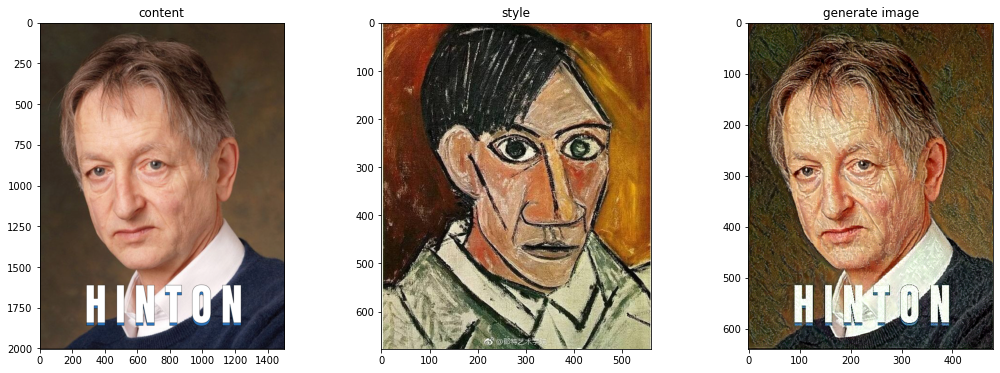

In [16]:
gen_images = transfer_style(
    content_path="./asset/1_image_style_transfer/hinton.png",
    style_path="./asset/1_image_style_transfer/picasso2.jpg",
    iterations=2000,
    lr=1e-3,
    style_weights=[5e4]*5,
    content_weights=[1]*5,
)

write_gif(gen_images, "./asset/1_image_style_transfer/hinton_picasso2v2.gif")
cv2.imwrite("./asset/1_image_style_transfer/hinton_picasso2v2.png", gen_images[-1][:,:,::-1])

欢迎大家拿自己的头像尝试一下 LOL

关注**布尔艺数**微信公众号，了解人工智能、数据科学更多有趣应用，学习知识。